# Dark Sky Positions direct from Catalogue

In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits as fits

import pkg_resources
pkg_resources.require("numpy==1.26.3")
import numpy as np

from dl import queryClient as qc
import pandas as pd
from scipy.spatial import distance_matrix

/Users/vernica/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# timer function
import functools
import time

def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer


In [3]:
from catalog_class import SkyCatalogue
catalog_all_bands = SkyCatalogue(all_bands=True)
catalog_g_band = SkyCatalogue(all_bands=False)

Loading masked star data....
Elapsed time: 1.8640 seconds
Defining grid lines...
Elapsed time: 0.0009 seconds
Elapsed time: 1.8653 seconds
Loading masked star data....
Elapsed time: 1.7757 seconds
Defining grid lines...
Elapsed time: 0.0009 seconds
Elapsed time: 1.7770 seconds


In [4]:
# 2x2 degree query square with all bands (griz) = 73.34 s
# this finds 218 dark sky positions in that area
positions_allbands, overlap_allbands = catalog_all_bands.create_catalogue(280, -30, 2, allsky=True)

# 2x2 degree query square with just g band = 37.66 s
# this finds 9716 dark sky positions in that area
positions_gband, overlap_gband = catalog_g_band.create_catalogue(280, -30, 2, allsky=True)


> Creating sky catalog from one 2-degree square starting from (280, -30) to (282, -28)
>> Querying the tractor catalog for stars from RA/DEC(280, -30) to (282, -28)...
Elapsed time: 9.3369 seconds
>> Looping through sky coordinates...
>>> Generating sky catalog for square RA,DEC (280, -30) to (281, -29)...
>>> 1-degree square with corner 280, -30 intersects with the galactic plane!
>>> Generating sky catalog for square RA,DEC (281, -30) to (282, -29)...
>>> 1-degree square with corner 280, -30 intersects with the galactic plane!
>>> Generating sky catalog for square RA,DEC (280, -29) to (281, -28)...
>>> 1-degree square with corner 280, -30 intersects with the galactic plane!
>>> Generating sky catalog for square RA,DEC (281, -29) to (282, -28)...
>>> 1-degree square with corner 280, -30 intersects with the galactic plane!
>> Removing positions from overlapping regions...
Elapsed time: 0.0097 seconds
>> Finding largest overlap for whole 2-degree square...
>> min RA/DEC = (280, -30)    

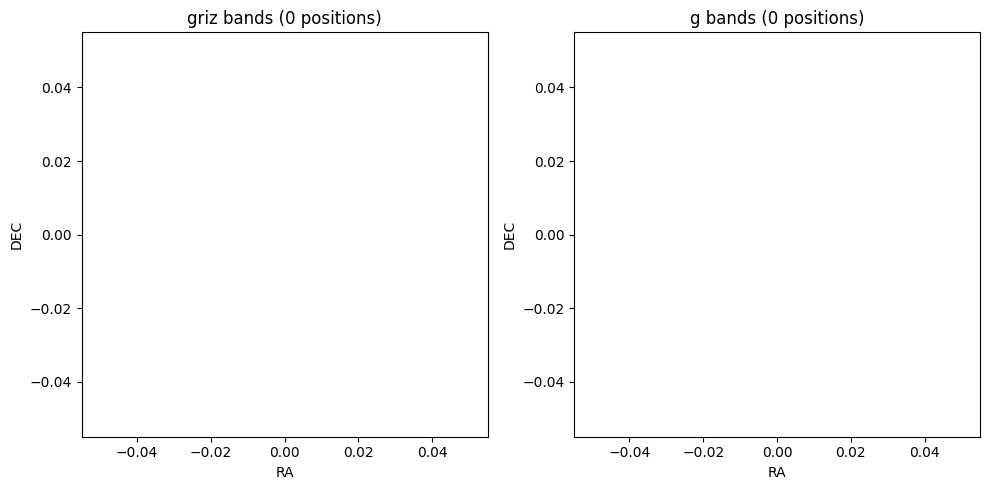

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(positions_allbands['ra'], positions_allbands['dec'], 'k.')
ax1.set(title=f"griz bands ({positions_allbands.size} positions)", xlabel="RA", ylabel="DEC")
ax2.plot(positions_gband['ra'], positions_gband['dec'], 'g.')
ax2.set(title=f"g bands ({positions_gband.size} positions)", xlabel="RA", ylabel="DEC")
plt.tight_layout()
plt.show()

In [ ]:
# 4x4 degree query square with all bands (griz) = 287.6 s
# this finds 484 dark sky positions in that area
positions_allsky_allbands = catalog_all_bands.all_sky(query_dist=2.0, min_dec=-3, max_dec=1, min_ra=3, max_ra=7)

# 4x4 degree query square with just g band = 162 s
# this finds 29290 dark sky positions in that area
positions_allsky_gband = catalog_g_band.all_sky(query_dist=2.0, min_dec=-3, max_dec=1, min_ra=3, max_ra=7)
# overlap_bounds = np.asarray(overlap_store)

================= WHOLE SKY =================
====== WHOLE SKY: Looping through sky coordinates... =====
====== 2.0-degree square starting from RA,DEC = 3.0, -3.0 ======
> Creating sky catalog from one 2.0-degree square starting from (3.0, -3.0) to (5.0, -1.0)
>> Querying the tractor catalog for stars from RA/DEC(3.0, -3.0) to (5.0, -1.0)...
Elapsed time: 20.0565 seconds
>> Looping through sky coordinates...
>>> Generating sky catalog for square RA,DEC (3.0, -3.0) to (4.0, -2.0)...
>>>> Combining mask and queried stars...
Elapsed time: 0.0003 seconds
Elapsed time: 0.2393 seconds
>>>> Calculating pixel values for stars....
Elapsed time: 0.0054 seconds
>>>> Creating segmentation map...
Elapsed time: 11.2163 seconds
>>>> Finding dark regions in segmentation map...
Elapsed time: 0.3720 seconds
>>>> Converting dark regions to coordinates...
Elapsed time: 0.0003 seconds
>>>> Finding maximum extent of stars beyond the degree-square bounds...
Elapsed time: 0.0012 seconds
>>>> Done!
Elapsed tim

/home/cworley/WiFeS_Catalog/catalog_class.py:462: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  larger_catalogue = pd.concat([larger_catalogue,cat],axis=0).reset_index(drop=True)


Elapsed time: 0.0003 seconds
Elapsed time: 0.1706 seconds
>>>> Calculating pixel values for stars....
Elapsed time: 0.0057 seconds
>>>> Creating segmentation map...
Elapsed time: 11.4546 seconds
>>>> Finding dark regions in segmentation map...
Elapsed time: 0.3695 seconds
>>>> Converting dark regions to coordinates...
Elapsed time: 0.0003 seconds
>>>> Finding maximum extent of stars beyond the degree-square bounds...
Elapsed time: 0.0010 seconds
>>>> Done!
Elapsed time: 12.0368 seconds
>>> Generating sky catalog for square RA,DEC (3.0, -2.0) to (4.0, -1.0)...
>>>> Combining mask and queried stars...
Elapsed time: 0.0003 seconds
Elapsed time: 0.1522 seconds
>>>> Calculating pixel values for stars....
Elapsed time: 0.0042 seconds
>>>> Creating segmentation map...
Elapsed time: 10.8359 seconds
>>>> Finding dark regions in segmentation map...
Elapsed time: 0.3250 seconds
>>>> Converting dark regions to coordinates...
Elapsed time: 0.0003 seconds
>>>> Finding maximum extent of stars beyond 

/home/cworley/WiFeS_Catalog/catalog_class.py:515: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  larger_catalogue = pd.concat([larger_catalogue,cat],axis=0).reset_index(drop=True)


Elapsed time: 19.9756 seconds
>> Looping through sky coordinates...
>>> Generating sky catalog for square RA,DEC (5.0, -3.0) to (6.0, -2.0)...
>>>> Combining mask and queried stars...
Elapsed time: 0.0004 seconds
Elapsed time: 0.2396 seconds
>>>> Calculating pixel values for stars....
Elapsed time: 0.0048 seconds
>>>> Creating segmentation map...
Elapsed time: 11.6132 seconds
>>>> Finding dark regions in segmentation map...
Elapsed time: 0.3609 seconds
>>>> Converting dark regions to coordinates...
Elapsed time: 0.0003 seconds
>>>> Finding maximum extent of stars beyond the degree-square bounds...
Elapsed time: 0.0008 seconds
>>>> Done!
Elapsed time: 12.2569 seconds
>>> Generating sky catalog for square RA,DEC (6.0, -3.0) to (7.0, -2.0)...
>>>> Combining mask and queried stars...


/home/cworley/WiFeS_Catalog/catalog_class.py:462: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  larger_catalogue = pd.concat([larger_catalogue,cat],axis=0).reset_index(drop=True)


Elapsed time: 0.0004 seconds
Elapsed time: 0.1782 seconds
>>>> Calculating pixel values for stars....
Elapsed time: 0.0050 seconds
>>>> Creating segmentation map...
Elapsed time: 11.1769 seconds
>>>> Finding dark regions in segmentation map...
Elapsed time: 0.2966 seconds
>>>> Converting dark regions to coordinates...
Elapsed time: 0.0003 seconds
>>>> Finding maximum extent of stars beyond the degree-square bounds...
Elapsed time: 0.0007 seconds
>>>> Done!
Elapsed time: 11.6923 seconds
>>> Generating sky catalog for square RA,DEC (5.0, -2.0) to (6.0, -1.0)...
>>>> Combining mask and queried stars...
Elapsed time: 0.0003 seconds
Elapsed time: 0.1450 seconds
>>>> Calculating pixel values for stars....
Elapsed time: 0.0044 seconds
>>>> Creating segmentation map...
Elapsed time: 11.0771 seconds
>>>> Finding dark regions in segmentation map...
Elapsed time: 0.3211 seconds
>>>> Converting dark regions to coordinates...
Elapsed time: 0.0005 seconds
>>>> Finding maximum extent of stars beyond 

/home/cworley/WiFeS_Catalog/catalog_class.py:462: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  larger_catalogue = pd.concat([larger_catalogue,cat],axis=0).reset_index(drop=True)


Elapsed time: 0.0005 seconds
Elapsed time: 0.1835 seconds
>>>> Calculating pixel values for stars....
Elapsed time: 0.0063 seconds
>>>> Creating segmentation map...
Elapsed time: 12.5198 seconds
>>>> Finding dark regions in segmentation map...
Elapsed time: 0.3955 seconds
>>>> Converting dark regions to coordinates...
Elapsed time: 0.0010 seconds
>>>> Finding maximum extent of stars beyond the degree-square bounds...
Elapsed time: 0.0010 seconds
>>>> Done!
Elapsed time: 13.1482 seconds
>>> Generating sky catalog for square RA,DEC (3.0, 0.0) to (4.0, 1.0)...
>>>> Combining mask and queried stars...
Elapsed time: 0.0003 seconds
Elapsed time: 0.1811 seconds
>>>> Calculating pixel values for stars....
Elapsed time: 0.0051 seconds
>>>> Creating segmentation map...
Elapsed time: 13.2222 seconds
>>>> Finding dark regions in segmentation map...
Elapsed time: 0.3868 seconds
>>>> Converting dark regions to coordinates...
Elapsed time: 0.0003 seconds
>>>> Finding maximum extent of stars beyond th

/home/cworley/WiFeS_Catalog/catalog_class.py:462: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  larger_catalogue = pd.concat([larger_catalogue,cat],axis=0).reset_index(drop=True)


Elapsed time: 0.0003 seconds
Elapsed time: 0.1648 seconds
>>>> Calculating pixel values for stars....
Elapsed time: 0.0045 seconds
>>>> Creating segmentation map...
Elapsed time: 11.6906 seconds
>>>> Finding dark regions in segmentation map...
Elapsed time: 0.3895 seconds
>>>> Converting dark regions to coordinates...
Elapsed time: 0.0003 seconds
>>>> Finding maximum extent of stars beyond the degree-square bounds...
Elapsed time: 0.0007 seconds
>>>> Done!
Elapsed time: 12.2887 seconds
>>> Generating sky catalog for square RA,DEC (5.0, 0.0) to (6.0, 1.0)...
>>>> Combining mask and queried stars...
Elapsed time: 0.0003 seconds
Elapsed time: 0.1903 seconds
>>>> Calculating pixel values for stars....
Elapsed time: 0.0060 seconds
>>>> Creating segmentation map...
Elapsed time: 14.2848 seconds
>>>> Finding dark regions in segmentation map...
Elapsed time: 0.4261 seconds
>>>> Converting dark regions to coordinates...
Elapsed time: 0.0003 seconds
>>>> Finding maximum extent of stars beyond th

/home/cworley/WiFeS_Catalog/catalog_class.py:462: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  larger_catalogue = pd.concat([larger_catalogue,cat],axis=0).reset_index(drop=True)


Elapsed time: 5.0092 seconds
>>>> Finding dark regions in segmentation map...
Elapsed time: 0.3486 seconds
>>>> Converting dark regions to coordinates...
Elapsed time: 0.0008 seconds
>>>> Finding maximum extent of stars beyond the degree-square bounds...
Elapsed time: 0.0004 seconds
>>>> Done!
Elapsed time: 5.5632 seconds
>>> Generating sky catalog for square RA,DEC (3.0, -2.0) to (4.0, -1.0)...
>>>> Combining mask and queried stars...
Elapsed time: 0.0002 seconds
Elapsed time: 0.1651 seconds
>>>> Calculating pixel values for stars....
Elapsed time: 0.0044 seconds
>>>> Creating segmentation map...
Elapsed time: 4.6586 seconds
>>>> Finding dark regions in segmentation map...
Elapsed time: 0.3703 seconds
>>>> Converting dark regions to coordinates...
Elapsed time: 0.0008 seconds
>>>> Finding maximum extent of stars beyond the degree-square bounds...
Elapsed time: 0.0008 seconds
>>>> Done!
Elapsed time: 5.2299 seconds
>>> Generating sky catalog for square RA,DEC (4.0, -2.0) to (5.0, -1.0)

/home/cworley/WiFeS_Catalog/catalog_class.py:515: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  larger_catalogue = pd.concat([larger_catalogue,cat],axis=0).reset_index(drop=True)


Elapsed time: 16.8491 seconds
>> Looping through sky coordinates...
>>> Generating sky catalog for square RA,DEC (5.0, -3.0) to (6.0, -2.0)...
>>>> Combining mask and queried stars...
Elapsed time: 0.0002 seconds
Elapsed time: 0.2635 seconds
>>>> Calculating pixel values for stars....
Elapsed time: 0.0055 seconds
>>>> Creating segmentation map...
Elapsed time: 4.5779 seconds
>>>> Finding dark regions in segmentation map...
Elapsed time: 0.3313 seconds
>>>> Converting dark regions to coordinates...
Elapsed time: 0.0008 seconds
>>>> Finding maximum extent of stars beyond the degree-square bounds...
Elapsed time: 0.0004 seconds
>>>> Done!
Elapsed time: 5.2087 seconds
>>> Generating sky catalog for square RA,DEC (6.0, -3.0) to (7.0, -2.0)...
>>>> Combining mask and queried stars...
Elapsed time: 0.0002 seconds
Elapsed time: 0.1666 seconds
>>>> Calculating pixel values for stars....
Elapsed time: 0.0041 seconds
>>>> Creating segmentation map...


/home/cworley/WiFeS_Catalog/catalog_class.py:462: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  larger_catalogue = pd.concat([larger_catalogue,cat],axis=0).reset_index(drop=True)


Elapsed time: 4.9834 seconds
>>>> Finding dark regions in segmentation map...
Elapsed time: 0.3334 seconds
>>>> Converting dark regions to coordinates...
Elapsed time: 0.0007 seconds
>>>> Finding maximum extent of stars beyond the degree-square bounds...
Elapsed time: 0.0007 seconds
>>>> Done!
Elapsed time: 5.5186 seconds
>>> Generating sky catalog for square RA,DEC (5.0, -2.0) to (6.0, -1.0)...
>>>> Combining mask and queried stars...
Elapsed time: 0.0002 seconds
Elapsed time: 0.1592 seconds
>>>> Calculating pixel values for stars....
Elapsed time: 0.0044 seconds
>>>> Creating segmentation map...
Elapsed time: 5.3518 seconds
>>>> Finding dark regions in segmentation map...
Elapsed time: 0.3313 seconds
>>>> Converting dark regions to coordinates...
Elapsed time: 0.0008 seconds
>>>> Finding maximum extent of stars beyond the degree-square bounds...
Elapsed time: 0.0006 seconds
>>>> Done!
Elapsed time: 5.8784 seconds
>>> Generating sky catalog for square RA,DEC (6.0, -2.0) to (7.0, -1.0)

/home/cworley/WiFeS_Catalog/catalog_class.py:462: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  larger_catalogue = pd.concat([larger_catalogue,cat],axis=0).reset_index(drop=True)


Elapsed time: 0.0061 seconds
>>>> Creating segmentation map...
Elapsed time: 5.3039 seconds
>>>> Finding dark regions in segmentation map...
Elapsed time: 0.3547 seconds
>>>> Converting dark regions to coordinates...
Elapsed time: 0.0007 seconds
>>>> Finding maximum extent of stars beyond the degree-square bounds...
Elapsed time: 0.0006 seconds
>>>> Done!
Elapsed time: 5.8634 seconds
>>> Generating sky catalog for square RA,DEC (3.0, 0.0) to (4.0, 1.0)...
>>>> Combining mask and queried stars...
Elapsed time: 0.0003 seconds
Elapsed time: 0.1703 seconds
>>>> Calculating pixel values for stars....
Elapsed time: 0.0059 seconds
>>>> Creating segmentation map...
Elapsed time: 5.3393 seconds
>>>> Finding dark regions in segmentation map...
Elapsed time: 0.3475 seconds
>>>> Converting dark regions to coordinates...
Elapsed time: 0.0007 seconds
>>>> Finding maximum extent of stars beyond the degree-square bounds...
Elapsed time: 0.0004 seconds
>>>> Done!
Elapsed time: 5.8950 seconds
>>> Genera

/home/cworley/WiFeS_Catalog/catalog_class.py:462: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  larger_catalogue = pd.concat([larger_catalogue,cat],axis=0).reset_index(drop=True)


Elapsed time: 0.0002 seconds
Elapsed time: 0.2132 seconds
>>>> Calculating pixel values for stars....
Elapsed time: 0.0051 seconds
>>>> Creating segmentation map...
Elapsed time: 5.2992 seconds
>>>> Finding dark regions in segmentation map...
Elapsed time: 0.3943 seconds
>>>> Converting dark regions to coordinates...
Elapsed time: 0.0009 seconds
>>>> Finding maximum extent of stars beyond the degree-square bounds...
Elapsed time: 0.0007 seconds
>>>> Done!
Elapsed time: 5.9432 seconds
>>> Generating sky catalog for square RA,DEC (5.0, 0.0) to (6.0, 1.0)...
>>>> Combining mask and queried stars...
Elapsed time: 0.0002 seconds
Elapsed time: 0.1744 seconds
>>>> Calculating pixel values for stars....
Elapsed time: 0.0046 seconds
>>>> Creating segmentation map...
Elapsed time: 5.2577 seconds
>>>> Finding dark regions in segmentation map...
Elapsed time: 0.3461 seconds
>>>> Converting dark regions to coordinates...
Elapsed time: 0.0006 seconds
>>>> Finding maximum extent of stars beyond the d

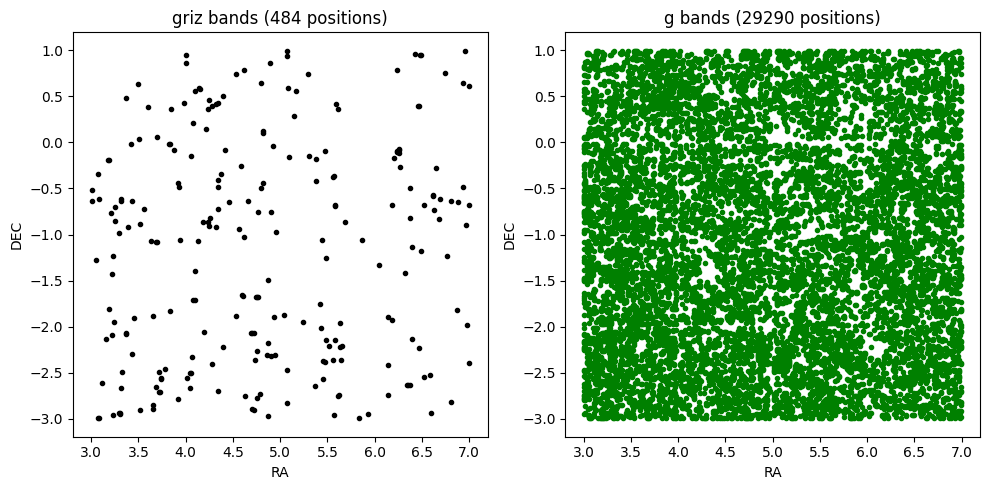

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(positions_allsky_allbands['ra'], positions_allsky_allbands['dec'], 'k.')
ax1.set(title=f"griz bands ({positions_allsky_allbands.size} positions)", xlabel="RA", ylabel="DEC")
ax2.plot(positions_allsky_gband['ra'], positions_allsky_gband['dec'], 'g.')
ax2.set(title=f"g bands ({positions_allsky_gband.size} positions)", xlabel="RA", ylabel="DEC")
plt.tight_layout()
plt.show()

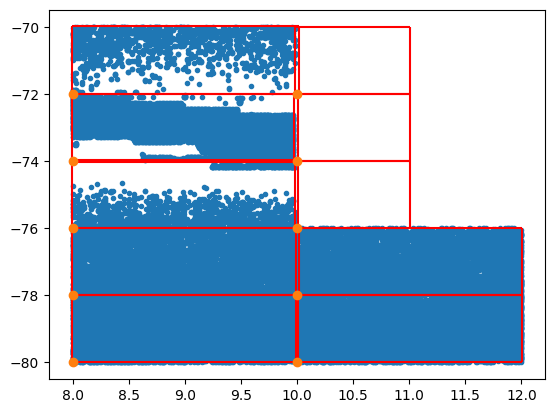

In [11]:
# ra_final = positions['ra']
# dec_final = positions['dec']

fig, ax = plt.subplots()
ax.plot(positions['ra'],positions['dec'],'.')
# ax.plot(larger_catalog['ra'], larger_catalog['dec'], '.')
for overlap in overlap_bounds:
    ax.vlines((overlap[0], overlap[2]), ymin=overlap[1], ymax=overlap[3], color="r")
    ax.hlines((overlap[1], overlap[3]), xmin=overlap[0], xmax=overlap[2], color="r")
ax.plot(ra_coords, dec_coords, 'o')
# ax.set(xlim=(8.9, 10.1), ylim=(-79.5, -78.5))
plt.show()

In [17]:
test_stars = query_tractor(8, -76, 4)
test_stars

Elapsed time: 29.3077 seconds


,ra,dec,mag_g,mag_r,mag_i,mag_z
0,10.358302,-75.455994,18.889627,18.123957,17.844513,17.699550
1,10.370592,-75.448497,18.336042,17.498804,17.198320,17.039814
2,10.379045,-75.446617,18.669088,17.873490,17.587801,17.429000
3,10.191436,-75.448574,20.949100,20.412073,20.228518,20.132673
4,10.230221,-75.450210,20.473692,19.612710,19.281511,19.088781
...,...,...,...,...,...,...
153283,11.335197,-72.318303,20.919832,20.407646,20.200298,20.142857
153284,11.334618,-72.317283,19.796532,19.203514,18.969694,18.889528
153285,11.314861,-72.322678,20.565674,20.763615,20.918020,21.094995
153286,11.311463,-72.321579,19.805172,19.220144,18.975378,18.904512


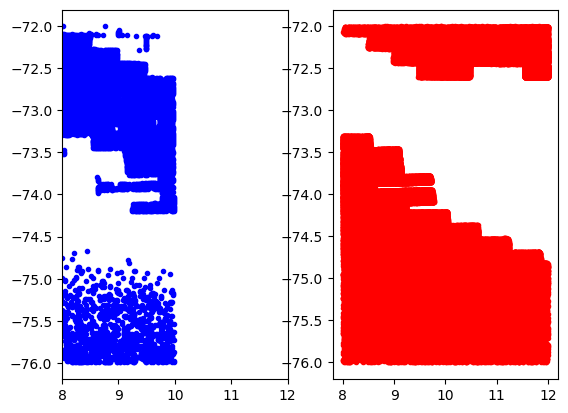

In [19]:
fig, ax = plt.subplots(1,2)
ax[0].plot(positions['ra'], positions['dec'], 'b.')
ax[0].set(xlim=(8,12))
ax[1].plot(test_stars['ra'], test_stars['dec'], 'r.')
plt.show()


In [8]:
big_box = pd.DataFrame({'ra': np.arange(0, 20), 'dec': np.arange(0,20)*2})
small_box = big_box.query('2 < ra < 12')
excluded = pd.concat((big_box, small_box)).drop_duplicates(keep=False)
# overlap = np.setdiff1d(big_box.index, small_box.index)


## Querying tractor catalogue for one degree squares

In [16]:
@timer
def query_tractor(ra, dec, dist=1.0):
    """Queries the Astro Data Lab for the ra, dec and mag_g of the objects within a square of side length (dist).     
    dist is in degrees
    """
    # Bounds of the square we are querying objects for
    ra_min=ra
    ra_max = ra + dist
    dec_min=dec
    dec_max = dec + dist
    
    query = f"""
            SELECT ra, dec, mag_g,mag_r,mag_i,mag_z
            FROM ls_dr10.tractor_s
            WHERE ra >= ({ra_min}) AND ra < ({ra_max})
            AND dec >= ({dec_min}) AND dec < ({dec_max})
            AND mag_g<=21 AND mag_g>=16     
            """

    # query = f"""
    # SELECT ra, dec, mag_g,mag_r,mag_i,mag_z
    # FROM ls_dr10.tractor_s
    # WHERE ra >= ({ra_min}) AND ra < ({ra_max})
    # AND dec >= ({dec_min}) AND dec < ({dec_max})
    # AND (mag_g<=21 AND mag_g>=16
    #     OR mag_r<=21 AND mag_r>=16
    #     OR mag_i<=21 AND mag_i>=16
    #     OR mag_z<=21 AND mag_z>=16)       
    # """
    
    # check if this completes successfuly
    brick_info = qc.query(sql=query, fmt="pandas")
    return brick_info

## Get bitmask info

In [13]:
@timer
def load_mask_data(index=0, load_all=False):
    """Load a desired mask data file by index, or just download all five. 
    Returns a pandas Dataframe with columns 'ra', 'dec', 'radius'
    """
    
    # load all
    if load_all:
        all_masks = []
        for i in range(5):
            
            with np.load(f"mask_data_{i}.npz", mmap_mode='r') as mask_data:
                mask_array = mask_data['arr_0']
                mask_array_byteswap = mask_array.byteswap().newbyteorder()
                masked_stars = pd.DataFrame(mask_array_byteswap)
                all_masks.append(masked_stars)
        return pd.concat(all_masks, ignore_index=True)

    # load single index
    with np.load(f"mask_data_{index}.npz", mmap_mode='r') as mask_data:
        mask_array = mask_data['arr_0']
        mask_array_byteswap = mask_array.byteswap().newbyteorder()
        masked_stars = pd.DataFrame(mask_array_byteswap)

    return masked_stars
    

## Process mask and catalog data together

In [14]:
# masking for low magnitude objects
@timer
def mask_radius(mag_g, mask_radius=20):
    return (mask_radius/3600) + 1630./3600. * 1.396**(-mag_g)

In [15]:
# combine mask and star data

@timer
def combine_data(masked_stars, catalog_stars, coords, mask_minimum):
    """Combines the data from masked and catalog stars based on some coordinate range"""
    # coords = [ra, ra+map_dist, dec, dec+map_dist]
    
    # cut masked stars to only use the same area as catalog_stars
    masked_box = masked_stars.query('(@coords[0] < ra < @coords[1]) and (@coords[2] < dec < @coords[3])')
    
    # apply buffer radius to mask and star data
    masked_box.loc[:, 'radius'] = masked_box['radius'] + (mask_minimum / 3600.)
    catalog_stars['radius'] = mask_radius(catalog_stars['mag_g'], mask_minimum)
    
    # remove g mag
    catalog_stars = catalog_stars.drop('mag_g', axis=1)
    
    # combine catalog + mask
    all_stars = pd.concat([masked_box, catalog_stars]).reset_index(drop=True)
    return all_stars

In [16]:
def create_pixel_columns(all_stars, coords, dim):
    """Creates columns for min and max ra and dec for all stars in the dataframe"""
    # coords: [ra, ra+map_dist, dec, dec+map_dist]
    
    # find max and min ra/dec corresponding to the mask of star
    all_stars['max_ra'] = all_stars['ra'] + all_stars['radius']
    all_stars['min_ra'] = all_stars['ra'] - all_stars['radius']
    all_stars['max_dec'] = all_stars['dec'] + all_stars['radius']
    all_stars['min_dec'] = all_stars['dec'] - all_stars['radius']
    
    # boolean for radii that go above 1-degree integer RA/DEC bounds
    expression = '(max_ra > ceil(ra)) | (min_ra < floor(ra)) | (max_dec > ceil(dec)) | (min_dec < floor(dec))'
    all_stars['overlap'] = all_stars.eval(expression)
    
    # ra, dec, and radius in pixels
    # TODO check if off by one is needed?
    all_stars['ra_pix'] = np.round((all_stars['ra'] - coords[0]) * dim).astype(int) - 1
    all_stars['dec_pix'] = np.round((all_stars['dec'] - coords[2]) * dim).astype(int) - 1
    all_stars['rad_pix'] = np.ceil(all_stars['radius'] * dim).astype(int)
    
    all_stars['min_ra_pix'] = all_stars['ra_pix'] - all_stars['rad_pix']
    all_stars['max_ra_pix'] = all_stars['ra_pix'] + all_stars['rad_pix']
    all_stars['min_dec_pix'] = all_stars['dec_pix'] - all_stars['rad_pix']
    all_stars['max_dec_pix'] = all_stars['dec_pix'] + all_stars['rad_pix']
    
    # set stars outside of map range to that value
    all_stars.loc[all_stars['min_ra_pix'] < 0, 'min_ra_pix'] = 0
    all_stars.loc[all_stars['max_ra_pix'] > dim, 'max_ra_pix'] = dim
    all_stars.loc[all_stars['min_dec_pix'] < 0, 'min_dec_pix'] = 0
    all_stars.loc[all_stars['max_dec_pix'] > dim, 'max_dec_pix'] = dim
    
    return all_stars
    
    

## Segmentation map

In [53]:
@timer
def seg_map(df:pd.DataFrame, dim):
    """Creates segementation map of shape (`dim`, `dim`) based on the mask locations and pixel data of `df`"""

    array = np.zeros((dim, dim), dtype=int)
    array.flatten()
    
    for star in df.to_dict('records'):
        
        # center pixel to determine distance from
        center = [[star['dec_pix'], star['ra_pix']]]
        
        # make array of indexes
        chunk = np.indices((star['max_dec_pix'] - star['min_dec_pix'], star['max_ra_pix'] - star['min_ra_pix']))
        
        # adjust indices to correspond to the larger grid
        # coord grid is shaped like [ [x1, y1], [x1, y2], ... [x1, yn], [x2, y1], ... [xn, yn] ]
        coord_grid = np.dstack((chunk[0]+star['min_dec_pix'], chunk[1]+star['min_ra_pix']))
        coord_grid = np.concatenate(coord_grid, axis=0)
        
        # calculate distances of each pixel coordinate to the center pixel
        distances = distance_matrix(x=coord_grid, y=center)

        # change all values of the segmap array to 0 where distances are < mask radius
        np.place(array[star['min_dec_pix']:star['max_dec_pix'], star['min_ra_pix']:star['max_ra_pix']], distances < star['rad_pix'], 1)

    array.reshape((dim, dim))
    return array

Loading masked star data....
Querying the tractor catalog for stars from RA(3, 4.0) to DEC(-4, -3.0)...
Combining mask and queried stars...
Elapsed time: 0.0003 seconds
Elapsed time: 0.2624 seconds
Calculating pixel values for stars....
Creating segmentation map...
Elapsed time: 4.5367 seconds
Defining grid lines...
Elapsed time: 0.0000 seconds
Finding dark regions...
Elapsed time: 0.3374 seconds
Plotting dark regions...


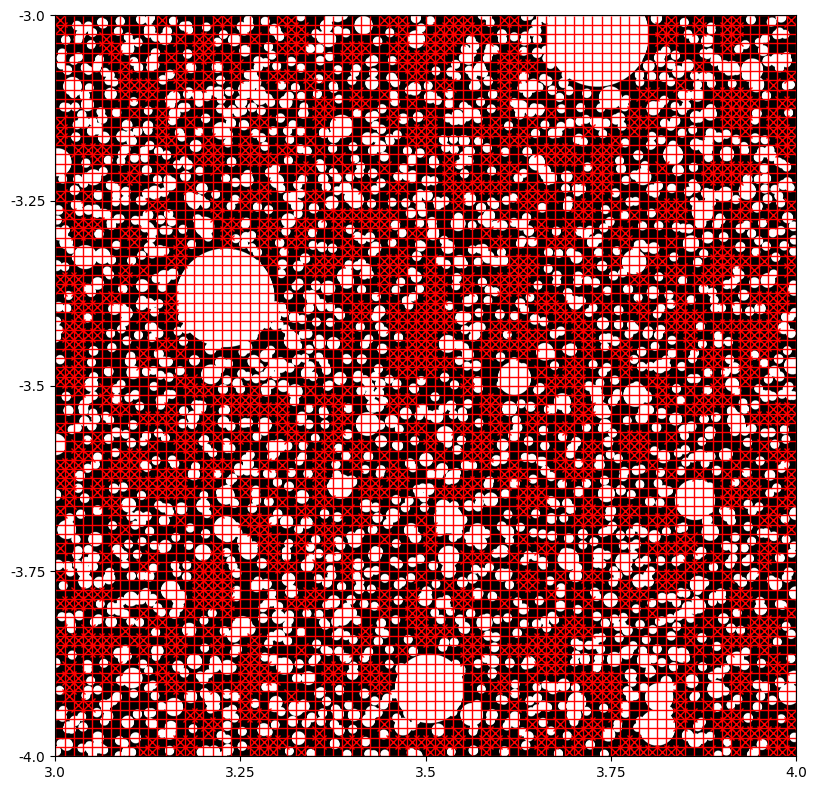

Elapsed time: 6.9951 seconds
Converting dark regions to coordinates...
Elapsed time: 0.0347 seconds
Done!
Elapsed time: 12.2060 seconds


,ra,dec
0,3.00625,-3.89375
1,3.00625,-3.85625
2,3.00625,-3.84375
3,3.00625,-3.83125
4,3.00625,-3.79375
...,...,...
1311,3.99375,-3.16875
1312,3.99375,-3.15625
1313,3.99375,-3.11875
1314,3.99375,-3.08125


In [ ]:
generate_dark_sky_catalogue(3,-4, query_df=query_df, mask_df=mask_df)

In [20]:
@timer
def define_grid(dim, fov=45):
    gridlines = np.arange(0, dim+1, (fov/3600 * dim))
    return gridlines

In [21]:
@timer
def find_dark_regions(array, gridlines):

    # calculating and storing the centre of each dark coord
    centers = []

    for i in range(len(gridlines[:-1])):
        centers.append(int((gridlines[i] + gridlines[i+1])/2 + 0.5))

    x_cen, y_cen = np.meshgrid(centers, centers)

    dark_regions = []

    for i in range(len(gridlines) - 1):
        for j in range(len(gridlines) - 1):
            x_start, x_end = (gridlines[i]).astype(int), (gridlines[i + 1]).astype(int)
            y_start, y_end = (gridlines[j]).astype(int), (gridlines[j + 1]).astype(int)
            
            if np.all(array[y_start:y_end, x_start:x_end] == 0):
                dark_regions.append([x_cen[j, i], y_cen[j, i]])

    dr_trans = np.array(dark_regions).transpose()

    return dr_trans, dark_regions

In [22]:
@timer
def create_plot(array, coords, pix_coords, gridlines, dim, dr_trans):

    # Creating exclusion map with grid
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.imshow(array, origin = 'lower', cmap='gray', vmin=0, vmax=1)

    positions = np.linspace(0,dim,5)
    x_labels = np.linspace(coords[0],coords[1],5)
    y_labels = np.linspace(coords[2],coords[3],5)

    ax.set_xticks(positions, x_labels)
    ax.set_yticks(positions, y_labels)    

    plt.vlines(gridlines, min(pix_coords[1]), max(pix_coords[1]), color='red', linewidth=1)
    plt.hlines(gridlines, min(pix_coords[0]), max(pix_coords[0]), color= 'red', linewidth=1)

    plt.plot(dr_trans[0], dr_trans[1], 'rx', markersize=10)

    plt.tight_layout()
    plt.margins(0)
    plt.show()

    return

In [23]:
@timer
def create_data_frame(dark_regions, coords, dim):
    dark_ra = []
    dark_dec = []

    for i in dark_regions:
        ra = i[0] / (dim) + coords[0]
        dec = i[1] / (dim) + coords[2]
        dark_ra.append(ra)
        dark_dec.append(dec)

    dark_catalogue = pd.DataFrame({'ra':dark_ra, 'dec':dark_dec})
    return dark_catalogue

In [24]:
@timer
def generate_dark_sky_catalogue(ra, dec, query_dist=1.0, map_dist=1.0, mask_min_radius=20, fov=45, query_df=None, mask_df=None):
    """Generates a dataframe of RA/DEC pairs corresponding to allowed dark positions
    
    Parameters
    ----------
    ra: `float`
        starting right ascension to query/analyze from (degrees)
    dec: `float`
        starting declination to query/analyze from (degrees)
    query_dist: `float`
        length of one side of the queried square region of sky from starting ra/dec (degrees, default=1)
    map_dist: `float`
        length of one side of the analyzed square region of sky from starting ra/dec (degrees, default=1)
    mask_min_radius: `float`
        minimum masking radius for detected objects (arcseconds, default=20)
    fov: `float`
        minimum spacing between dark sky regions (arcseconds, default=45)
    """
    
    dim = int((3600*4) * map_dist)
    
    # load masked data
    print("Loading masked star data....")
    # masked_stars = load_mask_data(load_all=True)
    masked_stars = mask_df
    
    print(f"Querying the tractor catalog for stars from RA({ra}, {ra+query_dist}) to DEC({dec}, {dec+query_dist})...")
    tractor_df = query_df
    # tractor_df = query_tractor(ra, dec, query_dist)
    
    # concatenate data
    print("Combining mask and queried stars...")
    coords = [ra, ra+map_dist, dec, dec+map_dist]
    all_stars = combine_data(masked_stars, tractor_df, coords, mask_min_radius)

    # return
    print("Calculating pixel values for stars....")
    all_stars = create_pixel_columns(all_stars, coords, dim)

    print("Creating segmentation map...")
    array = seg_map(all_stars, dim, coords)

    print("Defining grid lines...")
    gridlines = define_grid(dim, fov)

    print("Finding dark regions...")
    dr_trans, dark_regions = find_dark_regions(array, gridlines)

    print("Plotting dark regions...")
    pix_coords = [all_stars['ra_pix'], all_stars['dec_pix'], all_stars['rad_pix']]
    create_plot(array, coords, pix_coords, gridlines, dim, dr_trans)

    print("Converting dark regions to coordinates...")
    dark_catalogue = create_data_frame(dark_regions, coords, dim)
    
    print("Done!")

    return dark_catalogue

In [ ]:
query_df = query_tractor(3,-4, 1)
mask_df = load_mask_data(load_all=True)

Elapsed time: 8.2773 seconds
Elapsed time: 3.0782 seconds


Loading masked star data....
Querying the tractor catalog for stars from RA(3, 4.0) to DEC(-4, -3.0)...
Combining mask and queried stars...
Elapsed time: 0.0006 seconds
Elapsed time: 0.2844 seconds
Calculating pixel values for stars....
Creating segmentation map...
Elapsed time: 4.3274 seconds
Defining grid lines...
Elapsed time: 0.0000 seconds
Finding dark regions...
Elapsed time: 0.3228 seconds
Plotting dark regions...


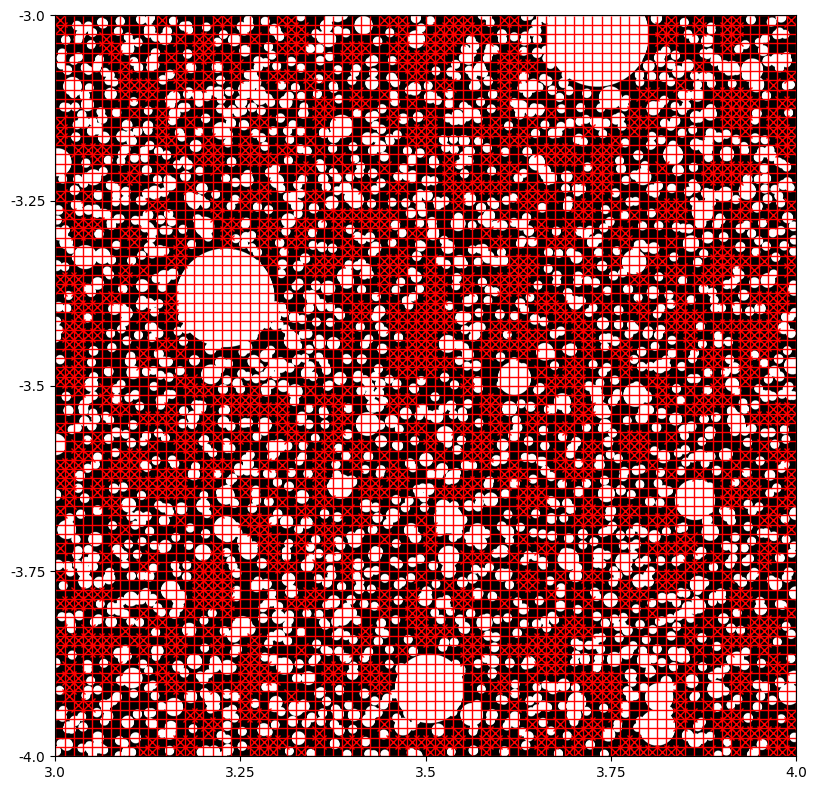

Elapsed time: 5.3751 seconds
Converting dark regions to coordinates...
Elapsed time: 0.0008 seconds
Done!
Elapsed time: 10.3461 seconds


,ra,dec
0,3.00625,-3.89375
1,3.00625,-3.85625
2,3.00625,-3.84375
3,3.00625,-3.83125
4,3.00625,-3.79375
...,...,...
1311,3.99375,-3.16875
1312,3.99375,-3.15625
1313,3.99375,-3.11875
1314,3.99375,-3.08125


In [30]:
generate_dark_sky_catalogue(3,-4, query_df=query_df, mask)